Setup

In [ ]:
!git clone https://github.com/MEGmax/nn-propagation-model-for-urban-areas.git
%pip -q install sionna-rt

import os, json, time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sionna.rt import (
    load_scene, PlanarArray, Transmitter, Receiver, Camera,
    RadioMapSolver
)

print("TF:", tf.__version__)

Cloning into 'nn-propagation-model-for-urban-areas'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 210 (delta 14), reused 23 (delta 13), pack-reused 172 (from 1)
Receiving objects: 100% (210/210), 45.83 MiB | 27.19 MiB/s, done.
Resolving deltas: 100% (63/63), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.7/271.7 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.7 MB/s eta 0:00:00
TF: 

 Load scene + define arrays + add RX

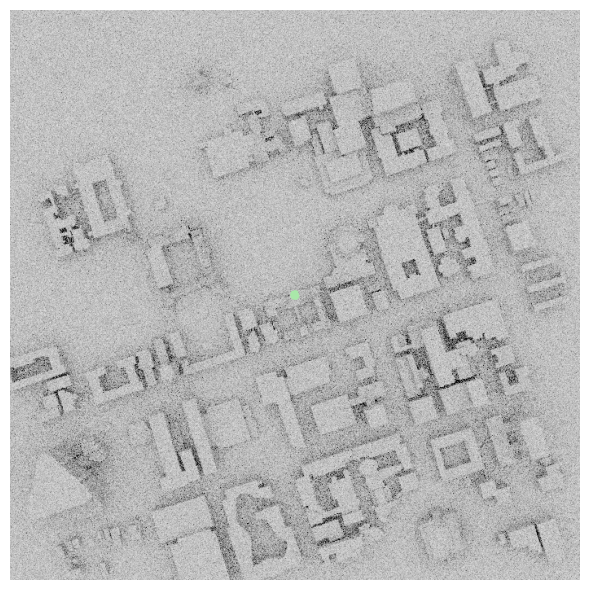

In [ ]:
# --- Load scene ---
SCENE_XML = "/content/nn-propagation-model-for-urban-areas/testing/colab_test/initialtest/firstscene.xml"
scene = load_scene(SCENE_XML)

# --- Antenna arrays (same as your example) ---
scene.tx_array = PlanarArray(
    num_rows=4, num_cols=4,
    vertical_spacing=0.5, horizontal_spacing=0.5,
    pattern="tr38901", polarization="V"
)

scene.rx_array = PlanarArray(
    num_rows=1, num_cols=1,
    vertical_spacing=0.5, horizontal_spacing=0.5,
    pattern="iso", polarization="V"
)

# --- Add a fixed receiver (edit as needed) ---
rx = Receiver("rx", position=[33, -1, 6], orientation=[0.0, 0.0, 0.0])
scene.add(rx)

# --- Camera for preview (optional) ---
my_cam = Camera(position=[0, 0, 1000], look_at=rx)

# Preview scene
scene.render(camera=my_cam, resolution=[700, 700], num_samples=2);

Define random TX sampler + solver config

In [ ]:
TX_BOUNDS = {
    "x": (-200.0, 200.0),
    "y": (-200.0, 200.0),
    "z": (  1.0,  10.0)   # keep above ground
}

def sample_tx_position(rng: np.random.Generator, bounds=TX_BOUNDS):
    x = rng.uniform(*bounds["x"])
    y = rng.uniform(*bounds["y"])
    z = rng.uniform(*bounds["z"])
    return [float(x), float(y), float(z)]

def sample_tx_orientation(rng: np.random.Generator):
    yaw = rng.uniform(0, 2*np.pi) # yaw only (common); adjust if you want roll/pitch too
    return [0.0, 0.0, float(yaw)]

RM_CONFIG = dict(
    max_depth=10,
    samples_per_tx=10**6,
    cell_size=(5, 5),
    center=[0, 0, 0],
    size=[600, 600],
    orientation=[0, 0, 0],
)

rm_solver = RadioMapSolver()

Run N random TX placements and save dataset

In [ ]:
import numpy as np

def to_pyfloat(x):
    """Convert drjit / numpy / tensorflow scalars to Python float safely."""
    try:
        return float(np.array(x))
    except Exception:
        pass
    try:
        return float(x.numpy())
    except Exception:
        pass
    return float(str(x))

def vec3_to_list(v):
    """Convert a 3D vector (tx.position, rx.position, orientation) to Python floats."""
    return [to_pyfloat(v[0]), to_pyfloat(v[1]), to_pyfloat(v[2])]

In [ ]:
from pathlib import Path

DATA_DIR = Path("/content/dataset_radiomaps")
DATA_DIR.mkdir(parents=True, exist_ok=True)

def extract_rss_grid(rm):
    """
    Tries to extract an RSS-like grid as a numpy array.
    Different Sionna RT versions may store metrics differently.
    """
    # Common pattern: rm.rss or rm.rss.numpy()
    if hasattr(rm, "rss"):
        rss = rm.rss
        try:
            return rss.numpy()
        except Exception:
            return np.array(rss)

    # Sometimes metrics are in rm.tensors or dict-like
    for key in ["rss", "RSS", "received_power", "rx_power"]:
        if hasattr(rm, key):
            val = getattr(rm, key)
            try:
                return val.numpy()
            except Exception:
                return np.array(val)

    # If nothing found, raise with debug info
    raise AttributeError(f"Couldn't find RSS grid. Available attrs: {dir(rm)[:50]} ...")

def ensure_single_tx(scene, name="tx"):
    # Remove old tx if it exists
    if name in scene.transmitters:
        scene.remove(name)

def generate_one_sample(scene, rng, sample_idx:int):
    ensure_single_tx(scene, "tx")

    tx_pos = sample_tx_position(rng)
    tx_ori = sample_tx_orientation(rng)

    tx = Transmitter("tx", position=tx_pos, orientation=tx_ori)
    scene.add(tx)

    rm = rm_solver(scene, **RM_CONFIG)
    rss_grid = extract_rss_grid(rm)

    sample_dir = DATA_DIR / f"sample_{sample_idx:06d}"
    sample_dir.mkdir(parents=True, exist_ok=True)

    np.save(sample_dir / "rss.npy", rss_grid)

    meta = {
        "sample_idx": int(sample_idx),
        "tx_position": vec3_to_list(tx.position),
        "tx_orientation": vec3_to_list(tx.orientation),
        "rx_position": vec3_to_list(rx.position),
        "rm_config": RM_CONFIG,
        "scene_xml": SCENE_XML,
        "rss_shape": list(rss_grid.shape),
    }
    with open(sample_dir / "meta.json", "w") as f:
        json.dump(meta, f, indent=2)

    return rm, rss_grid, meta

Generate Dataset

In [ ]:
N_SAMPLES = 50   # increase to thousands later
SEED = 12345
rng = np.random.default_rng(SEED)

t0 = time.time()
for i in range(N_SAMPLES):
    rm, rss_grid, meta = generate_one_sample(scene, rng, i)
    if (i % 10) == 0:
        print(f"[{i}/{N_SAMPLES}] saved {meta['rss_shape']} tx={meta['tx_position']}")

print("Done. Seconds:", time.time() - t0)
print("Dataset at:", str(DATA_DIR))

/tmp/ipython-input-3159586366.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(np.array(x))


[0/50] saved [1, 120, 120] tx=[-109.06558990478516, -73.29666137695312, 8.176289558410645]
[10/50] saved [1, 120, 120] tx=[-19.288516998291016, 66.01557159423828, 3.978018283843994]
[20/50] saved [1, 120, 120] tx=[53.81068420410156, -130.25035095214844, 3.233480453491211]
[30/50] saved [1, 120, 120] tx=[-67.41471099853516, -48.73735046386719, 4.121640682220459]
[40/50] saved [1, 120, 120] tx=[194.7227783203125, 81.46656799316406, 7.508416652679443]
Done. Seconds: 84.51597857475281
Dataset at: /content/dataset_radiomaps


Visualize (optinal not needed for saving it)

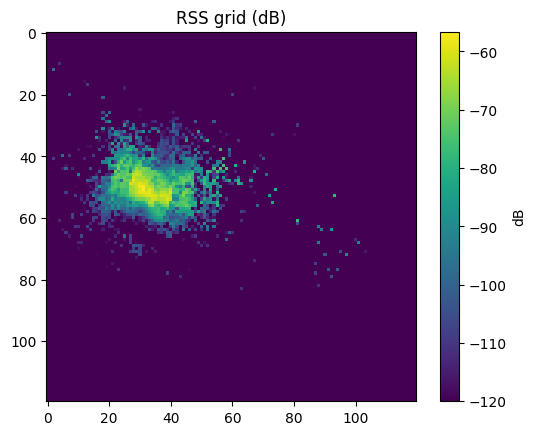

In [ ]:
img = np.squeeze(rss_grid).astype(np.float32)

# add tiny epsilon to avoid log(0)
img_db = 10*np.log10(np.maximum(img, 1e-12))

plt.figure()
plt.imshow(img_db)
plt.title("RSS grid (dB)")
plt.colorbar(label="dB")
plt.show()

In [ ]:
def build_npz_dataset(data_dir: Path, out_path: Path):
    samples = sorted([p for p in data_dir.iterdir() if p.is_dir() and p.name.startswith("sample_")])
    X = []
    M = []
    for p in samples:
        rss = np.load(p / "rss.npy")
        with open(p / "meta.json", "r") as f:
            meta = json.load(f)
        X.append(rss.astype(np.float32))
        M.append(meta)

    X = np.stack(X, axis=0)  # (N, H, W, ...) depending on rss shape
    np.savez_compressed(out_path, X=X, meta=json.dumps(M))
    return X.shape

out_npz = Path("/content/radiomap_dataset.npz")
shape = build_npz_dataset(DATA_DIR, out_npz)
print("Saved:", out_npz, "X shape:", shape)

Saved: /content/radiomap_dataset.npz X shape: (50, 1, 120, 120)


In [17]:
from google.colab import drive
drive.mount('/content/drive')

DRIVE_OUT = Path("/content/drive/MyDrive/sionna_dataset_radiomaps")
DRIVE_OUT.mkdir(parents=True, exist_ok=True)

!cp -r "{DATA_DIR}" "{DRIVE_OUT}/"
!cp -f "/content/radiomap_dataset.npz" "{DRIVE_OUT}/" 2>/dev/null || true

print("Copied to:", DRIVE_OUT)

Mounted at /content/drive
Copied to: /content/drive/MyDrive/sionna_dataset_radiomaps
